## Exercise SEP Developer Test

This test is designed to assess your ability to design and develop a project from a limited set of goals, provided below. We will evaluate your project based on its fulfillment of the outlined objectives, code efficiency, readability, and adherence to best practices. Additionally, we will evaluate the structure and content of your GitHub repository according to standard practices.

1. Please perform all coding within the Google Colab environment: http://colab.research.google.com
    * Please store your project in a GitHub repository, so we can fork and run it in Colab.
        * Additionally, please create a standard GitHub repository with the expected files and directory structure.    
    * Please note that Colab doesn't automatically include additional files. To avoid potential issues, we recommend only including files that the evaluators already have access to.    
    * The evaluators will use the files SEP01.mseed, SEP02.mseed, and SEP03.mseed, which can be found in this GitHub project.
2. Import the mseed files
3. Create a database with proper normal form and constraints
4. Import the data into the newly created database
5. Create a visualization for the data. The visualization can be static but must include:    
    * A title
    * Text section displaying metadata about the miniseed data
    * Helicorder-style charts of the miniseed data (These may be built from the database data or the mseed files)
    * A map with icons indicating station locations based on the miniseed data (station lat and lon can be found on iris' API)
    * Add to the map additional stations found on IRIS' data API. Stations of interest include HOA and SUG
        * Data API information can be found at http://service.iris.edu/fdsnws/station/1/



## Start Here

In [ ]:
# Start Here
#Install libaries needed from https://docs.obspy.org/packages/obspy.io.mseed.html
import os
# This is to setup the environment with the correct packages, and will restart the session for colab
# Check if restart flag file exists
if not os.path.exists("restart_flag.txt"):
    # Install Required Packages
    %pip install obspy pandas matplotlib folium sqlalchemy

    # Create a restart flag file
    with open("restart_flag.txt", "w") as f:
        f.write("restart")

    # Restart the runtime
    print("✅ Packages installed. Restarting runtime to apply changes...")
    os.kill(os.getpid(), 9)
else:
    # Remove the restart flag file
    os.remove("restart_flag.txt")

    # Continue with the rest of your code
    print("✅ Runtime restarted. Continuing with the next steps...")
    #Import post install
    import obspy
    import pandas as pd
    import matplotlib
    import folium
    from folium import Element, LayerControl, FeatureGroup
    import sqlalchemy
    import sqlite3
    import os
    import io
    import logging
    import gc
    import requests
    import unittest
    import matplotlib.pyplot as plt
    from folium.plugins import MarkerCluster, Search, TagFilterButton
    import base64
    from IPython.display import display
    from obspy import read
    print("✅ All packages successfully installed and imported.")

  Using cached obspy-1.4.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.7 kB)
ERROR: Could not find a version that satisfies the requirement unittest (from versions: none)
ERROR: No matching distribution found for unittest


## Section 1: Database creation, and data import

In [ ]:
# Configure logging
logging.basicConfig(
    filename='app.log',
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
# Ensure directory exists
def ensure_directory_exists(path):
    """
    Ensure that a directory exists. If it doesn't, create it.
    """
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"✅ Created missing directory: {path}")
    else:
        print(f"✅ Directory already exists: {path}")

def get_connection(db_path, db='seismic_data.db'):
    """Establish a database connection."""
    return sqlite3.connect(db_path + '/' + db)

def create_tables(cursor):
    """Create database tables for stations, recordings, and mseed data."""
# Create Stations Table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS stations (
        station_id INTEGER PRIMARY KEY AUTOINCREMENT,
        network TEXT,
        station TEXT,
        location TEXT,
        latitude REAL,
        longitude REAL,
        elevation REAL,
        site_name TEXT,
        UNIQUE(network, station)
    );
    ''')
    # Create Recordings Table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS recordings (
        recording_id INTEGER PRIMARY KEY AUTOINCREMENT,
        station_id INTEGER NOT NULL,
        starttime TEXT,
        endtime TEXT,
        format TEXT,
        channel TEXT,
        sampling_rate REAL,
        delta REAL NOT NULL,
        calib REAL,
        dataquality TEXT,
        encoding TEXT,
        npts INTEGER,
        number_of_records INTEGER,
        record_length INTEGER,
        filesize INTEGER,
        UNIQUE(station_id,format,channel,sampling_rate,delta,encoding,starttime, endtime),
        FOREIGN KEY(station_id) REFERENCES stations(station_id) ON DELETE CASCADE
    );
    ''')

    # Create mseed Data Table
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS mseed_data (
        mseed_id INTEGER PRIMARY KEY AUTOINCREMENT,
        recording_id INTEGER NOT NULL,
        data BLOB NOT NULL,
        UNIQUE(recording_id,data),
        FOREIGN KEY(recording_id) REFERENCES recordings(recording_id) ON DELETE CASCADE
    );
    ''')
def insert_station(cursor, network, station, location, latitude, longitude, elevation, site_name):
    """Insert station data into the stations table."""
    cursor.execute('''
        INSERT OR IGNORE INTO stations (network, station, location, latitude, longitude, elevation, site_name)
        VALUES (?, ?, ?, ?, ?, ?,?)
    ''', (network, station, location, latitude, longitude, elevation, site_name))

def insert_recording(cursor, station_id, starttime, endtime, format, channel, sampling_rate, delta, calib,
                dataquality, encoding, npts, record_length,  filesize, number_of_records):
    """Insert recording data into the recordings table."""
    cursor.execute('''
            INSERT OR IGNORE INTO recordings (
                station_id, starttime, endtime, format, channel, sampling_rate, delta, calib,
                dataquality, encoding, npts, record_length,  filesize, number_of_records
            )
            VALUES (
                ?,
                ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?
            )
    ''', (station_id, starttime, endtime, format, channel, sampling_rate, delta, calib,
                dataquality, encoding, npts, record_length,  filesize, number_of_records))

def batch_insert_mseed_data(cursor, recording_id,mseed):
    """Batch insert mseed data into the mseed_data table."""
    try:
            # Write mseed to MiniSEED binary format in memory
            buffer = io.BytesIO()
            mseed.write(buffer, format='MSEED')
            buffer.seek(0)  # Ensure pointer is at the beginning of the buffer
            if recording_id:
                cursor.execute('''
                    INSERT OR IGNORE INTO mseed_data (recording_id, data)
                    VALUES (?, ?)
                ''', (
                    recording_id[0],
                    buffer.getvalue()  # Binary MiniSEED data
                ))
                print(f"✅ mseed data inserted for recording_id: {recording_id[0]}")
            else:
                print("⚠️ No matching recording_id found for this mseed.")

    except Exception as e:
            print(f"❌ Failed to insert mseed data: {e}")

def import_streams(conn,cursor,file_path):
# Import the mseed files
# Define the folder containing MiniSEED files
  data_folder = 'SEP/'

# List all .mseed files in the folder
  mseed_files = [os.path.join(file_path, file) for file in os.listdir(file_path) if file.endswith('.mseed')]

# Read all MiniSEED files
  streams = []
  for file in mseed_files:
    try:
        streams.append(read(file))
        print(f"✅ Successfully loaded: {file}")
    except Exception as e:
        print(f"❌ Failed to load {file}: {e}")
  for stream in streams:
    for mseed in stream:
      insert_station(cursor,mseed.stats.network,
            mseed.stats.station,
            mseed.stats.location,
            None,  # Latitude (fetch from IRIS API later if needed)
            None,   # Longitude (fetch from IRIS API later if needed)
            None, # Elevation (fetch from IRIS API later if needed)
            None # Site_name (fetch from IRIS API later if needed)
        )
      #conn.commit()
      cursor.execute('''
                SELECT station_id FROM stations
                WHERE station = ? AND network = ?
            ''', (
                mseed.stats.station,
               mseed.stats.network
      ))
      station_id = cursor.fetchone()[0]
      insert_recording(cursor,
            station_id,
            str(mseed.stats.starttime),
            str(mseed.stats.endtime),
            mseed.stats._format,
            mseed.stats.channel,
            mseed.stats.sampling_rate,
            mseed.stats.delta,
            mseed.stats.calib,
            mseed.stats.mseed.get('dataquality'),
            mseed.stats.mseed.get('encoding'),
            mseed.stats.npts,
            mseed.stats.mseed.get('record_length'),
            mseed.stats.mseed.get('filesize'),
            mseed.stats.mseed.get('number_of_records')
            )
      #conn.commit()
      # Fetch recording_id
      cursor.execute('''
                SELECT recording_id FROM recordings
                WHERE starttime = ? AND endtime = ? AND station_id = ?
            ''', (
                str(mseed.stats.starttime),
                str(mseed.stats.endtime),
                station_id
      ))
      recording_id = cursor.fetchone()
      batch_insert_mseed_data(cursor, recording_id,mseed)
  print("✅ Station data successfully inserted into the database.")


## Section 2: Update MetaData of stations from mseed files

In [ ]:
def update_stations(conn,cursor):
# Fetch all known stations from the database
  stations_df = pd.read_sql_query('''
    SELECT station_id, network, station
    FROM stations
''', conn)

  print("✅ Retrieved known stations from the database.")
#Request the Long/Lat information from the IRIS API

# Base URL for IRIS Station API
  iris_api_url = "http://service.iris.edu/fdsnws/station/1/query"

# Iterate through each station and update metadata
  for index, row in stations_df.iterrows():
    params = {
        "network": row['network'],
        "station": row['station'],
        "level": "station",
        "format": "geocsv"
    }
  if stations_df is None or stations_df.empty:
    print("⚠️ Warning: The 'stations_df' DataFrame is null or empty. Import mseed data")
    print("❌ Check your database connection, query, or if mseed data was imported.")
    return None
  else:
    print(f"✅ Successfully loaded {len(stations_df)} stations from the database.")
  try:
          response = requests.get(iris_api_url, params=params)

          if response.status_code == 200:
              geocsv_data = response.text

            # Clean and parse the GEOCSV data
              cleaned_data = "\n".join(
                line for line in geocsv_data.splitlines()
                if not line.startswith("#") and "|" in line
            )

            # Parse with pipe delimiter
              geocsv_df = pd.read_csv(io.StringIO(cleaned_data), sep='|')

              if not geocsv_df.empty:
                # Extract metadata
                  latitude = geocsv_df.loc[0, 'Latitude'] if 'Latitude' in geocsv_df.columns else None
                  longitude = geocsv_df.loc[0, 'Longitude'] if 'Longitude' in geocsv_df.columns else None
                  site_name = geocsv_df.loc[0, 'SiteName'] if 'SiteName' in geocsv_df.columns else None
                # Update the station in the database
                  cursor.execute('''
                    UPDATE stations
                    SET latitude = ?, longitude = ?, site_name = ?
                    WHERE station_id = ?
                ''', (latitude, longitude,site_name, row['station_id']))

                  conn.commit()
                  print(f"✅ Updated station: {row['station']} with Latitude: {latitude}, Longitude: {longitude}")
              else:
                  print(f"⚠️ No valid data found for station {row['station']}")
          else:
              print(f"❌ Failed to fetch data for station {row['station']}. HTTP Status: {response.status_code}")

  except pd.errors.ParserError as e:
    print(f"❌ Parsing error for station {row['station']}: {e}")
  except Exception as e:
    print(f"❌ Error fetching/updating station {row['station']}: {e}")

# Fetch updated stations with latitude and longitude
  updated_stations_df = pd.read_sql_query('''
    SELECT station, network, latitude, longitude, site_name
    FROM stations
    WHERE latitude IS NOT NULL AND longitude IS NOT NULL
''', conn)

  print("✅ Updated station metadata:")
  print(updated_stations_df)
  # Query stations with missing latitude or longitude
  missing_data_df = pd.read_sql_query('''
    SELECT station, network, latitude, longitude
    FROM stations
    WHERE latitude IS NULL OR longitude IS NULL
  ''', conn)

  if missing_data_df.empty:
    print("✅ All stations have latitude and longitude.")
  else:
    print("⚠️ Some stations are missing latitude or longitude:")
    print(missing_data_df)

  duplicates_df = pd.read_sql_query('''
    SELECT station, COUNT(*)
    FROM stations
    GROUP BY station
    HAVING COUNT(*) > 1
''', conn)

  if duplicates_df.empty:
    print("✅ No duplicate station records found.")
  else:
    print("⚠️ Duplicate station records found:")
    print(duplicates_df)

## Section 3: Station API Import

In [ ]:
def import_stations_api(conn,cursor, filter=False):
# Populate additional Networks and stations into the database from the IRIS API
# Base URL for IRIS Station API
  iris_api_url = "http://service.iris.edu/fdsnws/station/1/query"

# Parameters for fetching the CC network
  if filter:
    station_params = {
    "network": filter,
    "level": "station",
    "format": "geocsv",
    "includeavailability": "true"
    }
  else:
    station_params = {
    "level": "station",
    "format": "geocsv",
    "includeavailability": "true"
    }

# Fetch station data for CC network
# Adjust the query to include a time range
  station_params["starttime"] = "1900-01-01"
  station_params["endtime"] = "2024-12-31"

  try:
      response = requests.get(iris_api_url, params=station_params)
      if response.status_code == 200:
          geocsv_data = response.text
          cleaned_data = "\n".join(
            line for line in geocsv_data.splitlines()
            if not line.startswith("#") and "|" in line
        )
          cc_stations_df = pd.read_csv(io.StringIO(cleaned_data), sep='|')
          print(cc_stations_df.head())
          print(f"✅ Successfully fetched {len(cc_stations_df)} stations after adjusting the time range.")
      else:
          print(f"❌ Failed to fetch with time range. HTTP Status: {response.status_code}")
  except Exception as e:
      print(f"❌ Error fetching stations with time range: {e}")

# Check the number of unique stations
  unique_stations_count = cc_stations_df['Station'].nunique()
  print(f"✅ Number of unique stations fetched: {unique_stations_count}")
# Insert recording metadata into the database
  try:
      for _, row in cc_stations_df.iterrows():
        location = row['location'] if pd.notnull(row.get('location')) else "Unknown Location"
        #location = "Unknown Location"
        insert_station(cursor,
            row['Network'],
            row['Station'],
            location,
            row['Latitude'],
            row['Longitude'],
            row['Elevation'],
            row['SiteName']
        )
      conn.commit()
      print("✅ Station data successfully inserted/updated into the database.")
  except Exception as e:
      print(f"❌ Error inserting station data: {e}")
# Verify total stations
  total_stations = pd.read_sql_query('SELECT COUNT(*) AS total FROM stations;', conn)
  print(f"✅ Total stations in database: {total_stations['total'][0]}")

## Section 4: Website Generation

In [ ]:
def get_station_metadata(conn):
# ✅ Step 1: Fetch Data
  station_metadata_df = pd.read_sql_query('''
    SELECT s.network, s.station, s.latitude, s.longitude, s.site_name,
           r.starttime, r.endtime, r.sampling_rate, r.channel, r.dataquality, r.delta, r.calib, r.format, r.number_of_records, r.encoding, r.npts,
           t.data AS mseed_data, r.recording_id
    FROM stations s
    LEFT JOIN recordings r ON s.station_id = r.station_id
    LEFT JOIN mseed_data t ON r.recording_id = t.recording_id;
''', conn)

  if station_metadata_df.empty:
    raise ValueError("⚠️ No valid mseed data found in the database.")

  print(f"✅ Retrieved data for {len(station_metadata_df)} map markers.")

# Ensure latitude and longitude are numeric, and drop rows with invalid values
  station_metadata_df['latitude'] = pd.to_numeric(station_metadata_df['latitude'], errors='coerce')
  station_metadata_df['longitude'] = pd.to_numeric(station_metadata_df['longitude'], errors='coerce')

# Drop rows with missing latitude or longitude
  station_metadata_df = station_metadata_df.dropna(subset=['latitude', 'longitude'])
  return station_metadata_df


def init_map(station_metadata_df):
# ✅ Step 2: Initialize the Map
  station_map = folium.Map(
    location=[station_metadata_df['latitude'].mean(), station_metadata_df['longitude'].mean()],
    zoom_start=6
  )
  return station_map

def helicorder_chart(mseed,starttime,endtime):
  time_axis = mseed.times('relative')
  amplitude = mseed.data
  # Generate Base64 Encoded Image for mseed Chart
  fig, ax = plt.subplots(figsize=(6, 3))
  ax.plot(time_axis, amplitude, lw=0.5)
  ax.set_title(f'Recording: {starttime} - {endtime}')
  ax.set_xlabel('Time (s)')
  ax.set_ylabel('Amplitude')
  plt.tight_layout()
  img_buffer = io.BytesIO()
  plt.savefig(img_buffer, format='png')
  plt.close()
  return base64.b64encode(img_buffer.getvalue()).decode('utf-8')


def add_markers(station_metadata_df,station_map):
# Custom JavaScript for Cluster Coloring
  custom_cluster = """
function(cluster) {
    let childMarkers = cluster.getAllChildMarkers();
    let hasMseed = childMarkers.some(function(marker) {
        return marker.options.icon.options.markerColor === 'green';
    });
    return L.divIcon({
        html: '<div style="background-color:' + (hasMseed ? 'green' : 'blue') + '; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; align-items: center; justify-content: center;">' + cluster.getChildCount() + '</div>',
        className: 'marker-cluster',
        iconSize: [30, 30]
    });
}
"""

# Create MarkerCluster
  marker_cluster = MarkerCluster(icon_create_function=custom_cluster).add_to(station_map)

# Dictionary for Search Plugin
  search_data = []

# ✅ Step 1: Add Markers for Each station
  for _, row in station_metadata_df.iterrows():
    try:
      has_mseed_data = not pd.isnull(row['mseed_data'])
      #If it has mseed data, build the helicord chart and imbed it in html
      if has_mseed_data:
        mseed_stream = read(io.BytesIO(row['mseed_data']))
        mseed = mseed_stream[0]
        img_base64 = helicorder_chart(mseed,row["starttime"],row["endtime"])
        popup_image = f"data:image/png;base64,{img_base64}"

        # Build Popup Content for Each mseed Metadata Section
        popup_content = f"""
<h4 style="margin-bottom: 8px;">Station: {row['station']} ({row['network']})</h4>
<p><b>Site:</b> {row['site_name']}</p>
<p><b>Network:</b> {row['network']}</p>
<table style="width:100%; border-collapse: collapse; font-size: 12px;">
    <tr>
        <th style="text-align:left; border-bottom: 1px solid #ddd;">Parameter</th>
        <th style="text-align:left; border-bottom: 1px solid #ddd;">Value</th>
    </tr>
    <tr><td><b>Start Time</b></td><td>{row['starttime']}</td></tr>
    <tr><td><b>End Time</b></td><td>{row['endtime']}</td></tr>
    <tr><td><b>Sampling Rate</b></td><td>{row['sampling_rate']} Hz</td></tr>
    <tr><td><b>Channel</b></td><td>{row['channel']}</td></tr>
    <tr><td><b>Delta</b></td><td>{row['delta']}</td></tr>
    <tr><td><b>Data Quality</b></td><td>{row['dataquality']}</td></tr>
    <tr><td><b>Calibration</b></td><td>{row['calib']}</td></tr>
    <tr><td><b>Encoding</b></td><td>{row['encoding']}</td></tr>
    <tr><td><b>Number of Points</b></td><td>{row['npts']}</td></tr>
    <tr><td><b>Format</b></td><td>{row['format']}</td></tr>
    <tr><td><b>Number of Records</b></td><td>{row['number_of_records']}</td></tr>
</table>
<img src="{popup_image}" style="width:100%;height:auto;margin-top:10px;border-radius:5px;box-shadow:0 2px 5px rgba(0,0,0,0.3);">
"""
        icon_color = 'green'
        mseed_tag = 'With Data'
      else:
        # Popup content for stations without mseed data
        popup_content = f"""
            <h4>Station:{row['station']}</h4>
            <p><b>Network:{row['network']}</p>
            <p><b>Site:</b> {row['site_name']}</p>
            <p><b>Status:</b> No mseed data available</p>
            """
        icon_color = 'blue'
        mseed_tag = 'Without Data'

        # Add Marker to the Map
      network_row = row['network'] if pd.notnull(row['network']) else 'Unknown Network'
        # Determine Tooltip Based on Data Availability
      if pd.notnull(row['mseed_data']) and pd.notnull(row['starttime']) and pd.notnull(row['endtime']):
        tooltip = f"{row['station']} - {row['network']}<br>Start: {row['starttime']} | End: {row['endtime']}"
      else:
        tooltip = f"{row['station']} - {row['network']}"

      marker = folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=folium.Popup(popup_content, max_width=400),
            tooltip=folium.Tooltip(tooltip),
            Station=row['station'] +' '+ network_row,
            Network=row['network'],
            #tags=tooltip,
            tags=[row['network'], mseed_tag],
            icon=folium.Icon(color=icon_color, icon='info-sign')
        )
      net = row['network']
      marker.add_child(folium.Element(f'data-tags="{net} {mseed_tag}"'))

      marker.add_to(marker_cluster)
        # Add to Search Data array
      search_data.append({
            #'tooltip': folium.GeoJsonTooltip(fields=[row['network'],row['station']]),
            'tooltip': tooltip,
            'location': [row['latitude'], row['longitude']]
        })


    except Exception as e:
        print(f"❌ Error adding marker for station {row['station']}: {e}")

# ✅ Step 4: Add Search Plugin
  search_plugin = Search(
    layer=marker_cluster,
    search_label='Station',  # Search by station and network tooltip
    placeholder="Search for Station or Network",
    collapsed=False,
    search_zoom=12
  ).add_to(station_map)
# ✅ Step 5: Add Tag Filter Plugin
  TagFilterButton(
    data=['With Data',
      'Without Data'
    ],
    openPopupOnHover=False,
    filterOnEveryClick=True,
    clear_text='Clear Filters'
    #filter_on='Network'
  ).add_to(station_map)


def add_legend(station_map):
  #Add a legend
  # ✅ Step 1: Define the Custom Legend HTML
  legend_html = """
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 180px;
    height: 100px;
    background-color: white;
    z-index: 1000;
    border-radius: 5px;
    box-shadow: 0 2px 5px rgba(0,0,0,0.3);
    font-size: 14px;
    padding: 10px;
">
    <h4 style="margin: 0; text-align: center;">Legend</h4>
    <div style="margin-top: 8px;">
        <div style="display: flex; align-items: center; margin-bottom: 5px;">
            <div style="background-color: green; width: 15px; height: 15px; margin-right: 8px; border-radius: 50%;"></div>
            <span>With MiniSEED Data</span>
        </div>
        <div style="display: flex; align-items: center;">
            <div style="background-color: blue; width: 15px; height: 15px; margin-right: 8px; border-radius: 50%;"></div>
            <span>No MiniSEED Data</span>
        </div>
    </div>
</div>
"""
# ✅ Step 2: Add the Legend to the Map
  legend = Element(legend_html)
  station_map.get_root().html.add_child(legend)


def add_title(station_map):
# ✅ Add Title to the Map
  title_html = """
<div style="
    position: fixed;
    top: 10px;
    left: 50%;
    transform: translateX(-50%);
    background-color: rgba(255, 255, 255, 0.8);
    z-index: 1000;
    font-size: 18px;
    font-weight: bold;
    padding: 8px 12px;
    border-radius: 5px;
    box-shadow: 0 2px 5px rgba(0,0,0,0.3);
    text-align: center;
">
    🌍 Seismic Station Map - MiniSEED Data Visualization
</div>
"""
  #Step 2: Add the title to the Map
  title = folium.Element(title_html)
  station_map.get_root().html.add_child(title)

def add_logo(station_map):
# ✅ Adds the USGS Logo to the Map
  logo_html = """
<div style="
    position: fixed;
    bottom: 5px;
    right: 25px;
    z-index: 1000;
    width: 100px;
    height: 100px;
    background: url('https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/thumbnails/image/USGS_logo_green.png?itok=k0Aj8udv') no-repeat center center;
    background-size: contain;
    border-radius: 5px;
    box-shadow: 0 2px 5px rgba(0,0,0,0.3);
">
</div>
"""
  # Add the logo to the map
  logo = folium.Element(logo_html)
  station_map.get_root().html.add_child(logo)

## Section 5: Main definition, variable setup, unit testing, and running the notebook

In [ ]:
def main():
    #Initialize Database
    #Creates a SQLite DB in the given file path, Default 'Data/'
    db_file_path = 'Data'
    ensure_directory_exists(db_file_path)
    conn = get_connection(db_file_path)
    cursor = conn.cursor()
    cursor.close()
    conn.close()
    conn = get_connection(db_file_path)
    cursor = conn.cursor()
    #Creates the tables
    create_tables(cursor)
    #imports the mseed files in the given path, default 'SEP/'
    mseed_file_path = 'SEP/'
    ensure_directory_exists(mseed_file_path)
    import_streams(conn,cursor,mseed_file_path)
    conn.commit()
    #Queries the IRIS API for the location data, and updates the station table
    update_stations(conn,cursor)
    conn.commit()
    #Imports stations using the IRIS API, the second arguement is used to filter
    # based off of the given network string,if you don't give a second arguement it will
    # import all the stations.
    #import_stations_api(conn,cursor, "CC")
    #import_stations_api(conn,cursor)
    network_filter = "CC"
    if network_filter:
      import_stations_api(conn,cursor, network_filter)
      file_name='station_mseed_map_'+network_filter +'.html'
    else:
      import_stations_api(conn,cursor)
      file_name='station_mseed_map_all.html'
    #
    conn.commit()

    # initializes the map, with markers, logos, legend, and title
    stations = get_station_metadata(conn)
    station_map = init_map(stations)
    add_markers(stations,station_map)
    add_logo(station_map)
    add_legend(station_map)
    add_title(station_map)
    #Display the map, and save locally
    display(station_map)
    station_map.save(file_name)
    #Clean up the env, incase you want to run main again
    cursor.close()
    conn.close()
    del cursor, conn, stations, station_map
    gc.collect()

### Section 5.1: Unit Testing

In [ ]:
# ----------------------------
# 📊 Test SQLite Database
# ----------------------------
class TestSQLiteDatabase(unittest.TestCase):
    TEST_DB = 'test_database1.db'
    PATH_DB = 'Test_Data'
    def setUp(self):
        self.conn = get_connection(self.PATH_DB,self.TEST_DB)
        self.cursor = self.conn.cursor()
        create_tables(self.cursor)

    def tearDown(self):
        self.conn.close()
        if os.path.exists(self.PATH_DB + '/' +self.TEST_DB):
            os.remove(self.PATH_DB + '/' + self.TEST_DB)

    def test_connection(self):
        self.assertIsNotNone(self.conn)
        self.assertIsNotNone(self.cursor)

    def test_table_creation(self):
        self.cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = [row[0] for row in self.cursor.fetchall()]
        expected_tables = ['stations', 'recordings', 'mseed_data']
        for table in expected_tables:
            self.assertIn(table, tables)


# ----------------------------
# 📊 Test Data Imports
# ----------------------------
class TestDataImports(unittest.TestCase):
    TEST_DB = 'test_database2.db'
    PATH_DB = 'Test_Data'
    TEST_MSEED_PATH = 'Test_Data/'

    def setUp(self):
        os.makedirs(self.TEST_MSEED_PATH, exist_ok=True)
        self.conn = get_connection(self.PATH_DB,self.TEST_DB)
        self.cursor = self.conn.cursor()
        create_tables(self.cursor)

    def tearDown(self):
        self.conn.close()
        if os.path.exists(self.PATH_DB + '/' +self.TEST_DB):
            os.remove(self.PATH_DB + '/' +self.TEST_DB)

    def test_import_streams(self):
        import_streams(self.conn, self.cursor, self.TEST_MSEED_PATH)
        self.cursor.execute("SELECT COUNT(*) FROM mseed_data;")
        count = self.cursor.fetchone()[0]
        self.assertGreater(count, 0, "No MiniSEED data was imported.")


# ----------------------------
# 📊 Test API Polling
# ----------------------------
class TestAPIPolling(unittest.TestCase):
    TEST_DB = 'test_database3.db'
    PATH_DB = 'Data'
    TEST_MSEED_PATH = 'Test_Data/'
    def setUp(self):
        os.makedirs(self.TEST_MSEED_PATH, exist_ok=True)
        self.conn = get_connection(self.PATH_DB,self.TEST_DB)
        self.cursor = self.conn.cursor()
        create_tables(self.cursor)

    def tearDown(self):
        self.conn.close()
        if os.path.exists(self.PATH_DB + '/' +self.TEST_DB):
            os.remove(self.PATH_DB + '/' +self.TEST_DB)

    def test_api_response(self):
        api_url = "http://service.iris.edu/fdsnws/station/1/query"
        params = {
            "network": "CC",
            ""
            "level": "station",
            "format": "geocsv"
        }
        try:
            response = requests.get(api_url, params=params)
            self.assertEqual(response.status_code, 200, "API did not return status 200.")
        except requests.exceptions.RequestException as e:
            self.fail(f"API Request failed: {e}")

    def test_api_data_parsing(self):
        data = import_stations_api(self.conn, self.cursor,"CC")
        self.cursor.execute("SELECT COUNT(*) FROM stations;")
        count = self.cursor.fetchone()[0]
        self.assertGreater(count, 0, "No API station data was imported.")

.

  Network Station   Latitude   Longitude  Elevation  \
0      CC    AHAB  46.194790 -122.187027    2298.00   
1      CC    ARAT  46.789000 -121.853000    1822.44   
2      CC    ASBU  43.820560 -121.368401    1538.00   
3      CC    ASCR  46.135570 -121.499010    1692.68   
4      CC    ATOM  46.027422 -121.274334     581.04   

                         SiteName                 StartTime  \
0  Ahab the whale(back) rider MSH  2005-02-08T00:00:00.0000   
1                    Mount Ararat  2020-08-06T00:00:00.0000   
2                 Astronaut Butte  2011-08-17T00:00:00.0000   
3      Adams South Climbers Route  2024-09-30T00:00:00.0000   
4                     Tom's Place  2024-10-09T00:00:00.0000   

                    EndTime  
0  2005-02-17T00:00:00.0000  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  
✅ Successfully fetched 97 stations after adjusting the time range.
✅ Number of unique stations fetched: 97
✅ S

....
----------------------------------------------------------------------
Ran 5 tests in 1.933s

OK


✅ Successfully loaded: Test_Data/test.mseed
✅ mseed data inserted for recording_id: 1
✅ mseed data inserted for recording_id: 2
✅ mseed data inserted for recording_id: 3
✅ mseed data inserted for recording_id: 4
✅ mseed data inserted for recording_id: 5
✅ mseed data inserted for recording_id: 6
✅ mseed data inserted for recording_id: 7
✅ mseed data inserted for recording_id: 8
✅ mseed data inserted for recording_id: 9
✅ mseed data inserted for recording_id: 10
✅ mseed data inserted for recording_id: 11
✅ mseed data inserted for recording_id: 12
✅ mseed data inserted for recording_id: 13
✅ mseed data inserted for recording_id: 14
✅ mseed data inserted for recording_id: 15
✅ Station data successfully inserted into the database.
✅ Directory already exists: Data
✅ Directory already exists: SEP/
✅ Successfully loaded: SEP/SEP01.mseed
✅ Successfully loaded: SEP/SEP02.mseed
✅ Successfully loaded: SEP/SEP03.mseed
✅ mseed data inserted for recording_id: 1
✅ mseed data inserted for recording_id:


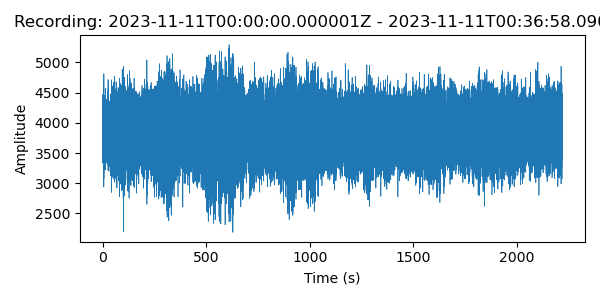
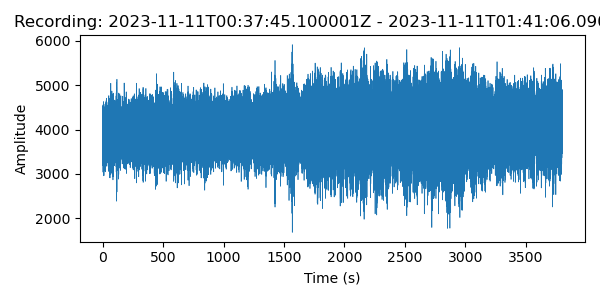
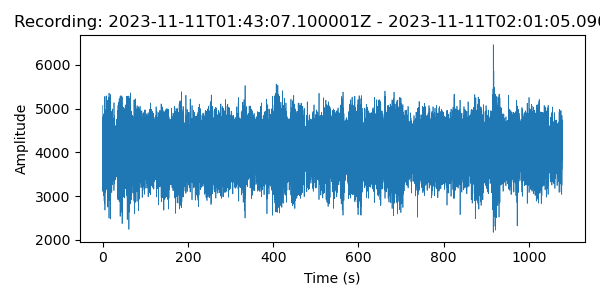
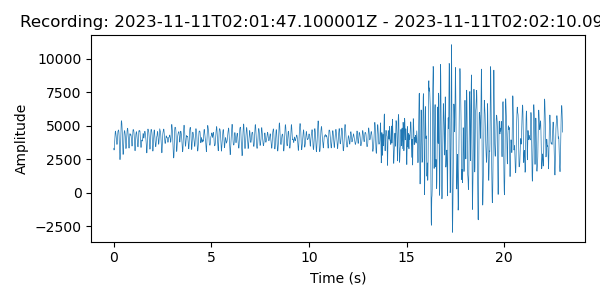
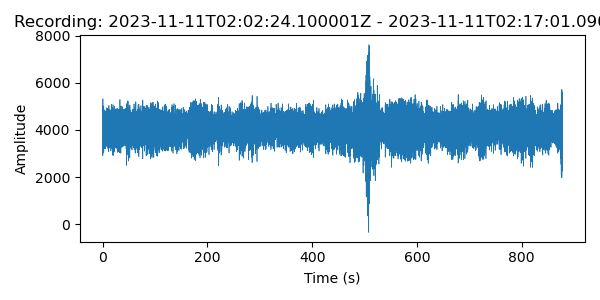
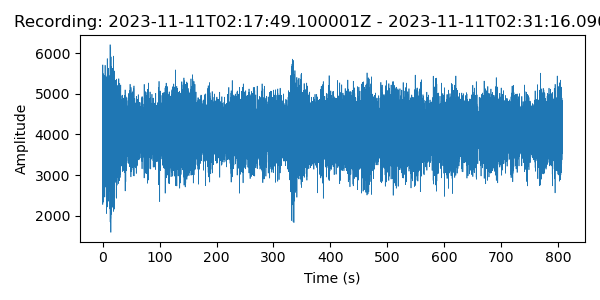
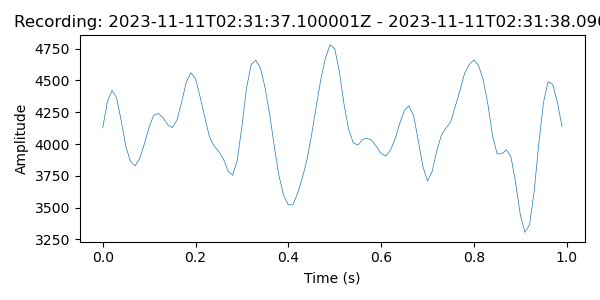
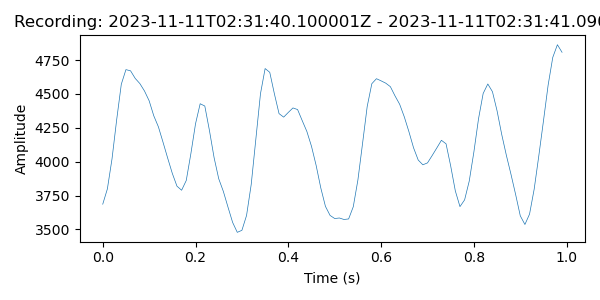
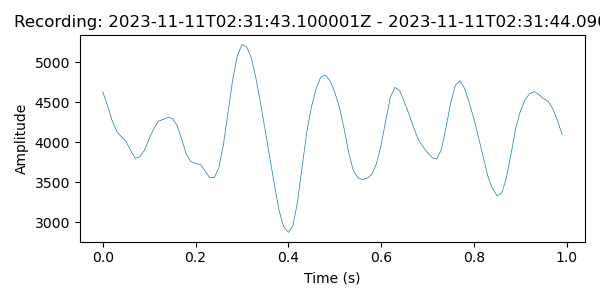
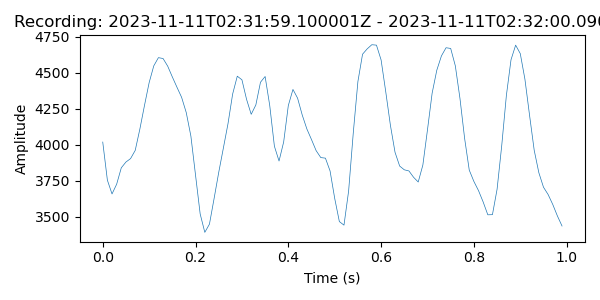
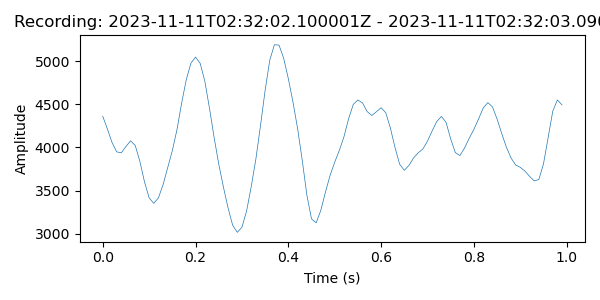
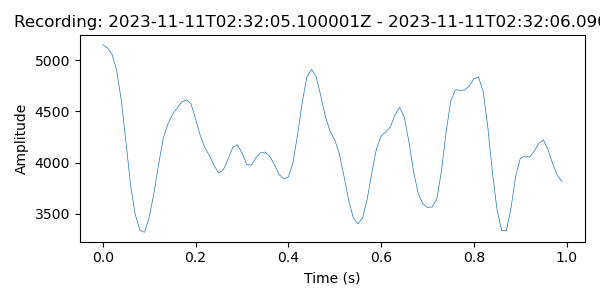
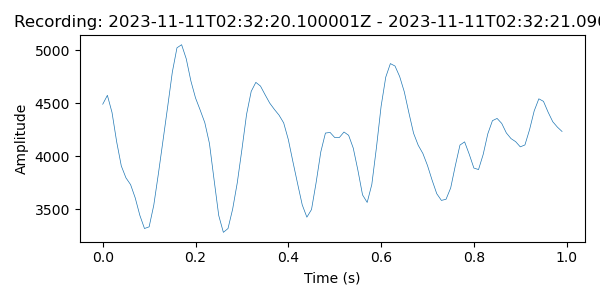
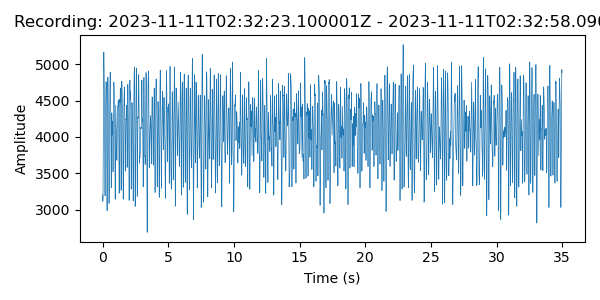
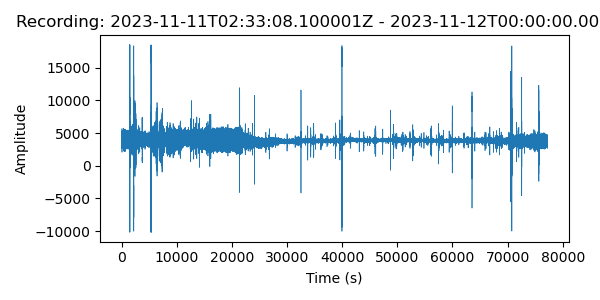
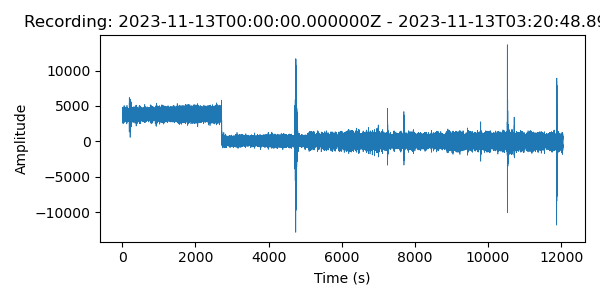
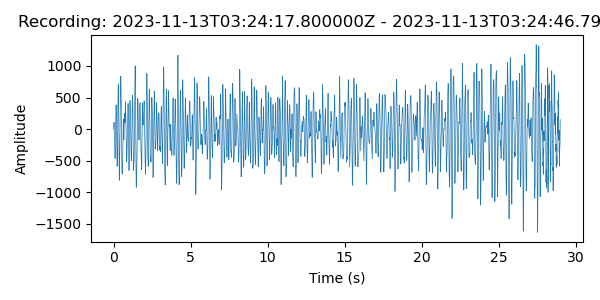
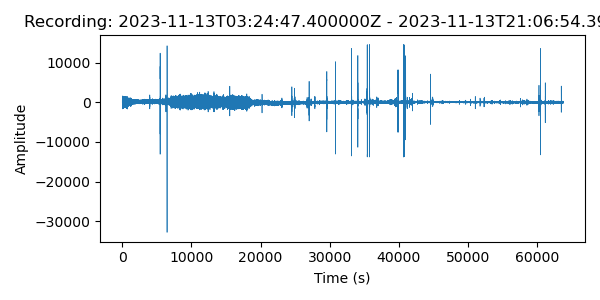
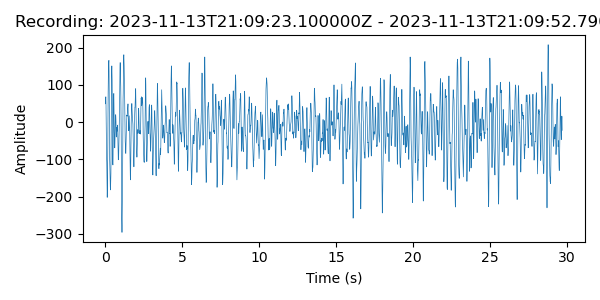
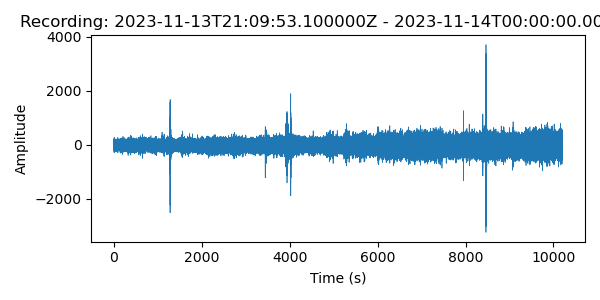
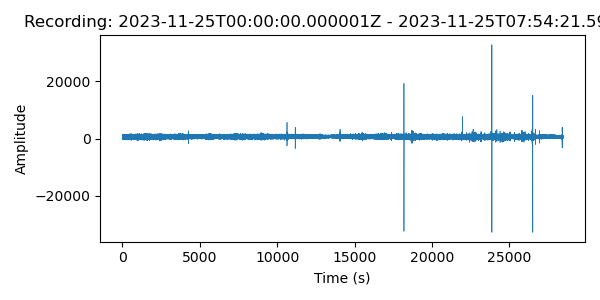
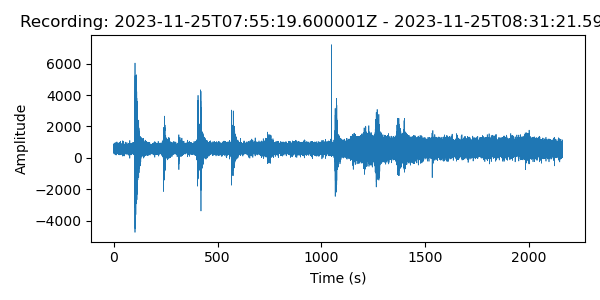
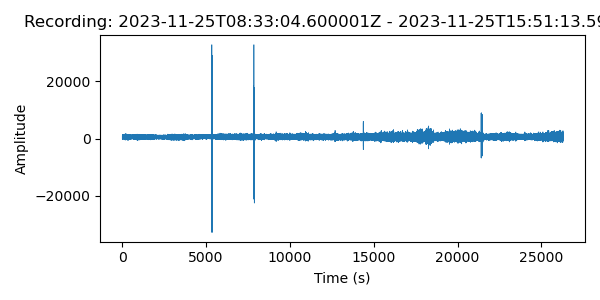
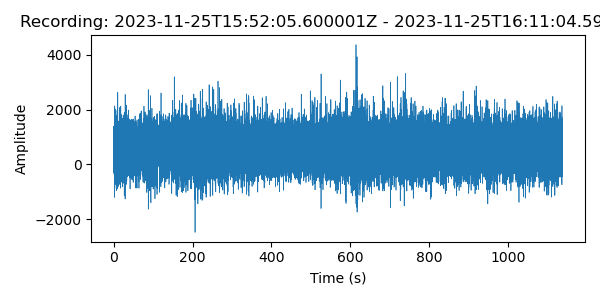
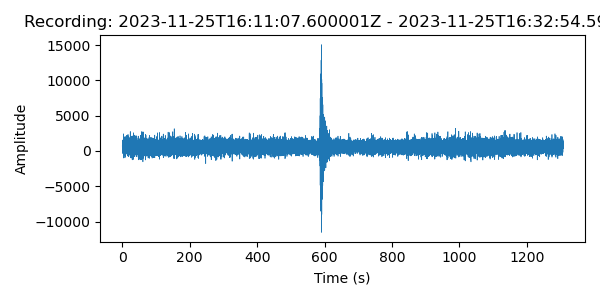
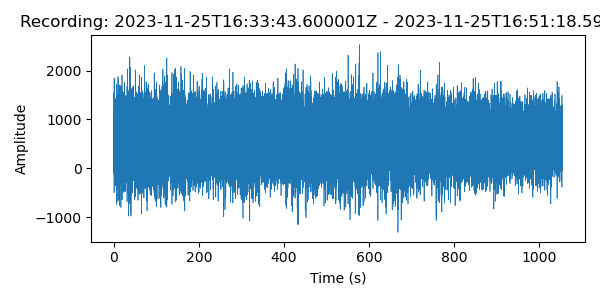
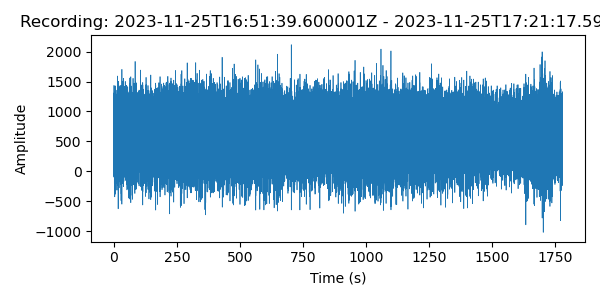
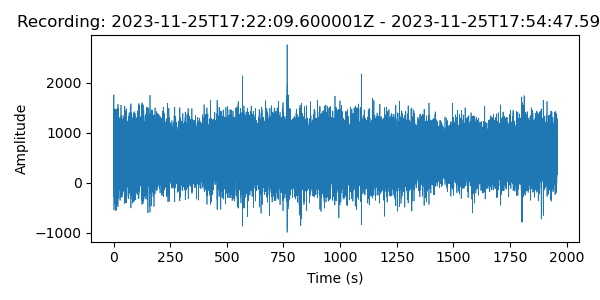
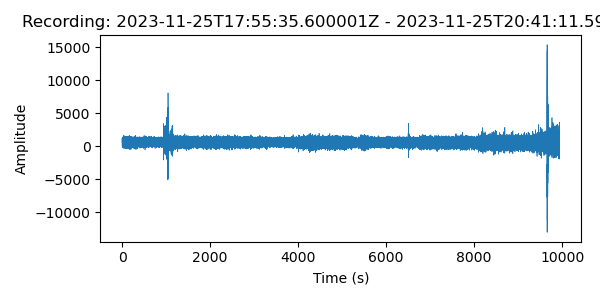
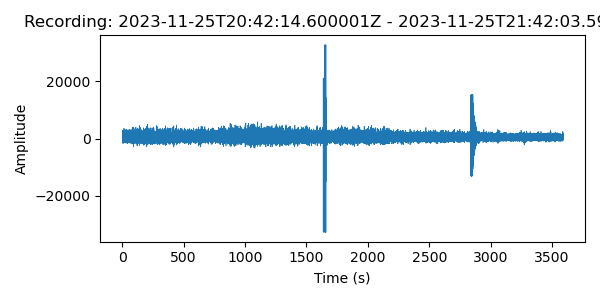
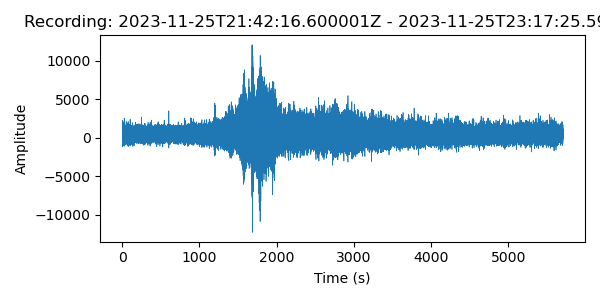
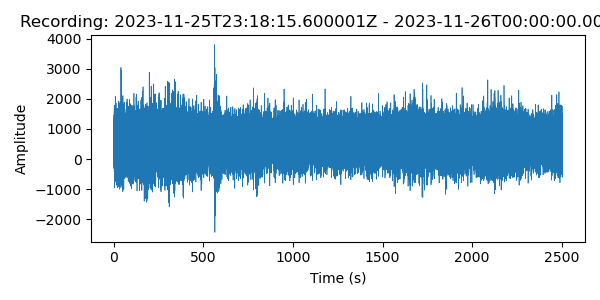

In [ ]:
if __name__ == '__main__':
    #comment out unit testing if you need if you don't need it
    #Be sure to make sure you have a 'Test_Data' directory and a single mseed file in it
    unittest.main(argv=[''], exit=False)
    main()